In [16]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier




data = pd.read_csv('online_shoppers_intention.csv')
data = pd.read_csv(os.path.join(os.getcwd(),'online_shoppers_intention.csv'))

In [17]:
data_info = data.info()
data_head = data.head()
data_describe = data.describe()

data_info, data_head, data_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12202 non-null  float64
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12195 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  OperatingSystems         12207 non-null  float64
 11  Browser                  12330 non-null  int64  
 12  Region                   12330 non-null  int64  
 13  TrafficType              12330 non-null  int64  
 14  VisitorType           

(None,
    Administrative  Administrative_Duration  Informational  \
 0               0                      0.0            0.0   
 1               0                      0.0            0.0   
 2               0                      0.0            0.0   
 3               0                      0.0            0.0   
 4               0                      0.0            0.0   
 
    Informational_Duration  ProductRelated  ProductRelated_Duration  \
 0                     0.0               1                 0.000000   
 1                     0.0               2                64.000000   
 2                     0.0               1                 0.000000   
 3                     0.0               2                 2.666667   
 4                     0.0              10               627.500000   
 
    BounceRates  ExitRates  PageValues  SpecialDay  OperatingSystems  Browser  \
 0         0.20       0.20         0.0         0.0               1.0        1   
 1         0.00       0.10   

In [18]:
# Checking for number of unique values for each feature
uniques_alternative = {column: data[column].nunique() for column in data.columns}
uniques_alternative

{'Administrative': 27,
 'Administrative_Duration': 3335,
 'Informational': 17,
 'Informational_Duration': 1258,
 'ProductRelated': 311,
 'ProductRelated_Duration': 9551,
 'BounceRates': 1872,
 'ExitRates': 4777,
 'PageValues': 2681,
 'SpecialDay': 6,
 'OperatingSystems': 8,
 'Browser': 13,
 'Region': 9,
 'TrafficType': 20,
 'VisitorType': 3,
 'Weekend': 2,
 'Revenue': 2}

In [19]:
# Visualize the data

# Ensure 'Revenue' column is in a suitable format for plotting
data['Revenue'] = data['Revenue'].astype('category')


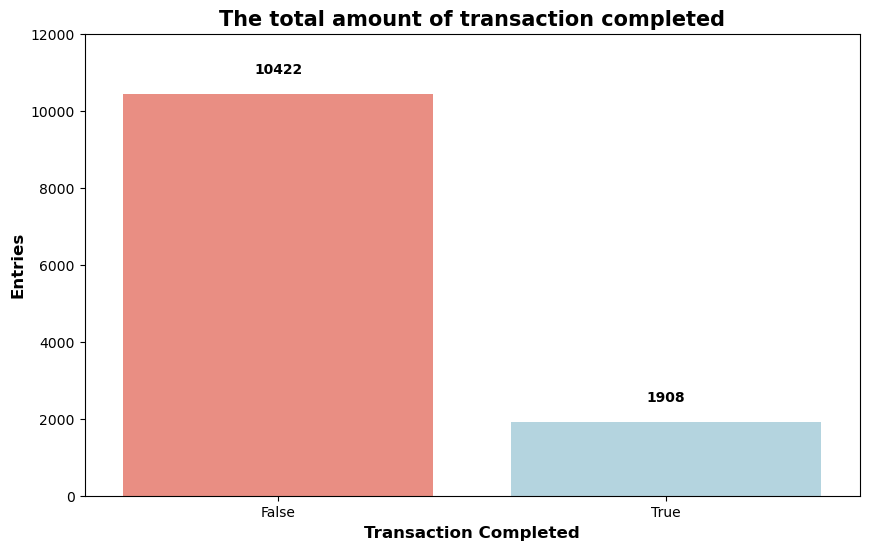

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Revenue', data=data, palette=['salmon', 'lightblue'])
plt.ylim(0, 12000)
plt.title('The total amount of transaction completed', fontsize= 15, fontweight='bold')
plt.xlabel('Transaction Completed', fontsize=12, fontweight='bold')
plt.ylabel('Entries', fontsize=12, fontweight='bold')

# Count the occurrences of each category in 'Revenue'
counts = data['Revenue'].value_counts()

# Annotating the count above each bar
for i, count in enumerate(counts):
    plt.text(x=i, y=count + 550, s=str(count), ha='center', fontsize=10, fontweight='bold')

plt.show()

In [21]:
monthly_counts = data['Month'].value_counts()

# Create a bar plot showing the number of entries per month
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Month', order=month_order)
plt.title('Entries per Month', fontsize=15)
plt.ylim(0, 4000)

# Adding text annotations to each bar
xval = -0.42
for month in month_order:
    count = monthly_counts[month]
    plt.text(x=xval, y=count+50, s=str(count), ha='center')
    xval += 1.02

plt.show()

# Now we will drop the 'Month' column based on the reasoning provided
data = data.drop(columns=['Month'])

# Displaying the first few rows of the data to confirm the 'Month' column is dropped
data.head()

KeyError: 'Month'

In [22]:
data_clean = data.drop(['Browser', 'OperatingSystems', 'Region', 'TrafficType', 'Weekend'], axis=1)


In [23]:
# Assuming 'data' is your DataFrame and has the same structure as the 'shopping' DataFrame from the example

# Removing unnecessary columns
data_clean = data.drop(['Browser', 'OperatingSystems', 'Region', 'TrafficType', 'Weekend'], axis=1)

# Label and One Hot Encoding
# Encoding 'VisitorType' with One Hot Encoding
visitor_encoded = pd.get_dummies(data_clean['VisitorType'], prefix='Visitor_Type', drop_first=True)

# Merging the new one hot encoded columns back into the original DataFrame
data_clean_merged = pd.concat([data_clean, visitor_encoded], axis=1).drop(['VisitorType'], axis=1)

# Splitting the data into train and test sets
X = data_clean_merged.drop('Revenue', axis=1)
y = data_clean_merged['Revenue']

# Splitting into train and test (assuming a 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50, test_size=0.1)

# Display the shapes of the train and test sets to verify
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# We can see here that the 'Month' column is missing January and April. We can see visually that several months have many samples (May, Nov) and a couple have very few samples (Feb, June).
# We will remove this column.''

((11097, 12), (1233, 12), (11097,), (1233,))

In [24]:


# Encode categorical columns using LabelEncoder
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Fill missing values with the mode (most frequent value) of each column
for column in data.columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

# Split the dataset into features (X) and the target variable (y)
X = data.drop('Revenue', axis=1)  # Assuming 'Revenue' is the target variable
y = data['Revenue']

# Convert the target variable to numerical format if it's categorical
if data['Revenue'].dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)

# Print the accuracy
print(f'Gaussian Naive Bayes model accuracy (in %): {accuracy * 100:.2f}')

Gaussian Naive Bayes model accuracy (in %): 83.98


In [25]:
# Encode categorical columns using LabelEncoder
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])

# Fill missing values with the mode (most frequent value) of each column
for column in data.columns:
    if data[column].isnull().any():
        data[column].fillna(data[column].mode()[0], inplace=True)

# Split the dataset into features (X) and the target variable (y)
# Assuming 'Revenue' is the target variable
X = data.drop('Revenue', axis=1)
y = data['Revenue']

# Convert the target variable to numerical format if it's categorical
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier with specific parameters
rfc = RandomForestClassifier(max_depth=5, random_state=2, n_estimators=750)

# Train the classifier
rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rfc = rfc.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred_rfc)

# Print the accuracy
print(f'Random Forest Classifier model accuracy (in %): {accuracy * 100:.2f}')

Random Forest Classifier model accuracy (in %): 88.20


In [26]:
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])

# Handle missing values (if any)
for column in data.columns:
    if data[column].isnull().any():
        data[column].fillna(data[column].mode()[0], inplace=True)

# Split the dataset into features (X) and the target variable (y)
# Assuming 'Revenue' is the target variable and it's located in the last column
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Convert the target variable to numerical format if it's categorical
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Extra Trees Classifier
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
etc.fit(X_train, y_train)

# Make predictions on the test data
y_pred_etc = etc.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred_etc)

# Print the accuracy
print(f'Extra Trees Classifier model accuracy (in %): {accuracy * 100:.2f}')

Extra Trees Classifier model accuracy (in %): 88.08


In [29]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


The area under the ROC curve is: 0.90


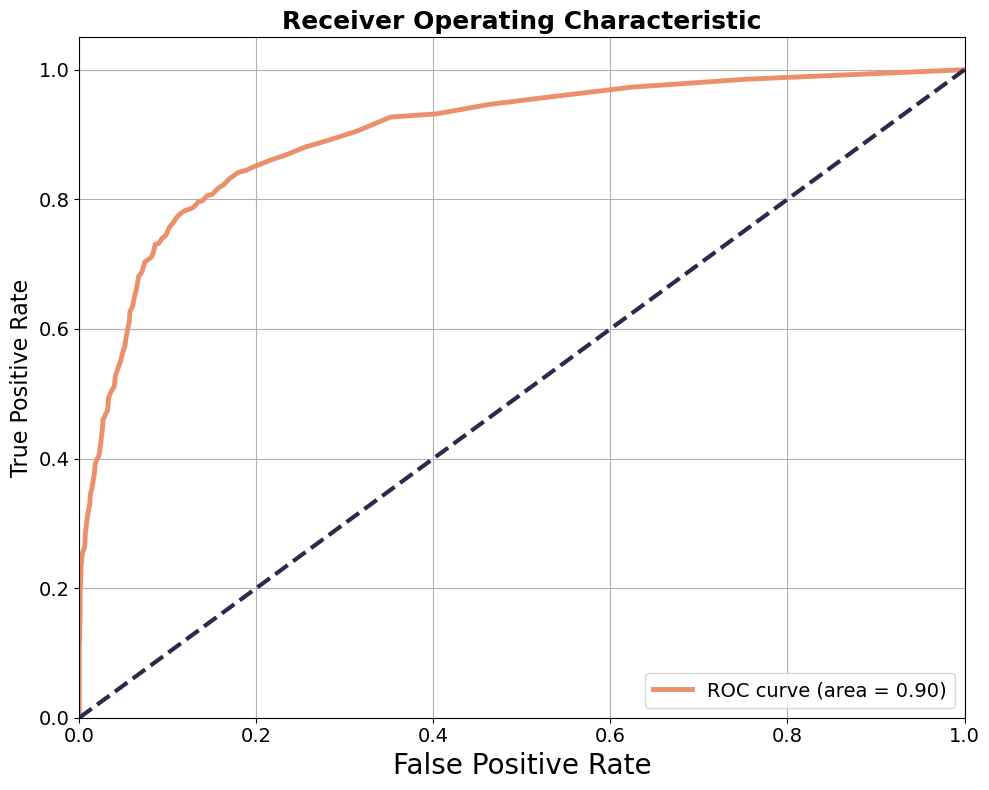

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
classifier = RandomForestClassifier(random_state=42)

# Fit the model to the training data
classifier.fit(X_train, y_train)

# Predict the probabilities of the positive class
y_probs = classifier.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_value = metrics.roc_auc_score(y_test, y_probs)
print(f'The area under the ROC curve is: {roc_value:.2f}')

# Generate ROC curve data
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve with enhanced styling
plt.figure(figsize=(10, 8))  # Bigger figure size for better visibility
plt.title('Receiver Operating Characteristic', fontsize=18, weight='bold')
plt.plot(fpr, tpr, color='#EA906C', lw=3.5, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='#2B2A4C', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)  # Add grid for better readability
plt.legend(loc="lower right", fontsize=14)
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

In [40]:
from sklearn.metrics import log_loss

In [42]:
rfc_log_loss = log_loss(y_test, y_probs)  # eps is not specified and will use the default behavior

print(f'Log Loss: {rfc_log_loss:.2f}')

Log Loss: 0.34


In [45]:
print(data.columns)
print(data.columns.tolist())

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')
['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


In [46]:
# Check if the columns exist in the DataFrame before processing
columns_to_check = ['feature1', 'feature2', 'feature3']
missing_columns = [col for col in columns_to_check if col not in data.columns]

if not missing_columns:
    # Proceed with your operations here
    data['mean_feature'] = data[['feature1', 'feature2', 'feature3']].mean(axis=1)
    # ... rest of your code ...
else:
    print(f"The following columns are missing from the DataFrame: {missing_columns}")


The following columns are missing from the DataFrame: ['feature1', 'feature2', 'feature3']
